In [46]:
import os
from nilearn import image
from nilearn.image import math_img
from nilearn import plotting
import numpy as np
import pandas as pd
from nilearn.input_data import NiftiMasker
from nilearn.image import load_img
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from statannotations.Annotator import Annotator

In [47]:
# Settings
data_dir = '/DATAPOOL/BRAINPLAYBACK/BIDS-BRAINPLAYBACK-TASK1/'
space_label = "MNI152NLin2009cAsym"
derivatives_folder = "derivatives/fmriprep/fmriprep"
task_label = "01"
out_dir = os.path.join(data_dir,"derivatives","nilearn_glm")
out_dir_group = os.path.join(data_dir,"derivatives","nilearn_glm","group")
sub_labels = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19']

In [48]:
# condition names
condition_names = ['Q1_p','Q2_p','Q3_p','Q4_p']

# create strings for contrasts in the format of "condition_name - Noise"
contrasts = []

# add contrast all conditions vs. noise
contrasts.append("Q1_p + Q2_p + Q3_p + Q4_p - Noise*4")

# iterate to add the other contrasts
for condition in condition_names:
    contrasts.append(condition + " - Noise")

# add more contrasts based on the arousal and valence
contrasts.append("Q1_p*0.5 + Q2_p*0.5 - Q3_p*0.5 - Q4_p*0.5") # positive arousal vs. negative arousal
contrasts.append("Q1_p*0.5 + Q4_p*0.5 - Q3_p*0.5 - Q2_p*0.5") # positive valence vs. negative valence

# just for fun - each Q against the other
contrasts.append("Q1_p - Q2_p")
contrasts.append("Q1_p - Q3_p")
contrasts.append("Q1_p - Q4_p")
contrasts.append("Q2_p - Q3_p")
contrasts.append("Q2_p - Q4_p")
contrasts.append("Q3_p - Q4_p")

contrasts_renamed = ['Q1234MinusNoise',
                     'Q1MinusNoise',
                     'Q2MinusNoise',
                     'Q3MinusNoise',
                     'Q4MinusNoise',
                     'PositiveArousalMinusNegativeArousal',
                     'PositiveValenceMinusNegativeValence',
                     'Q1MinusQ2',
                     'Q1MinusQ3',
                     'Q1MinusQ4',
                     'Q2MinusQ3',
                     'Q2MinusQ4',
                     'Q3MinusQ4']

contrastList = contrasts_renamed[1:5]

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]


/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task01/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/DATAPOOL/home/alexandresayal/anaconda3/envs/brainplayback_task01/lib/python3.9/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(



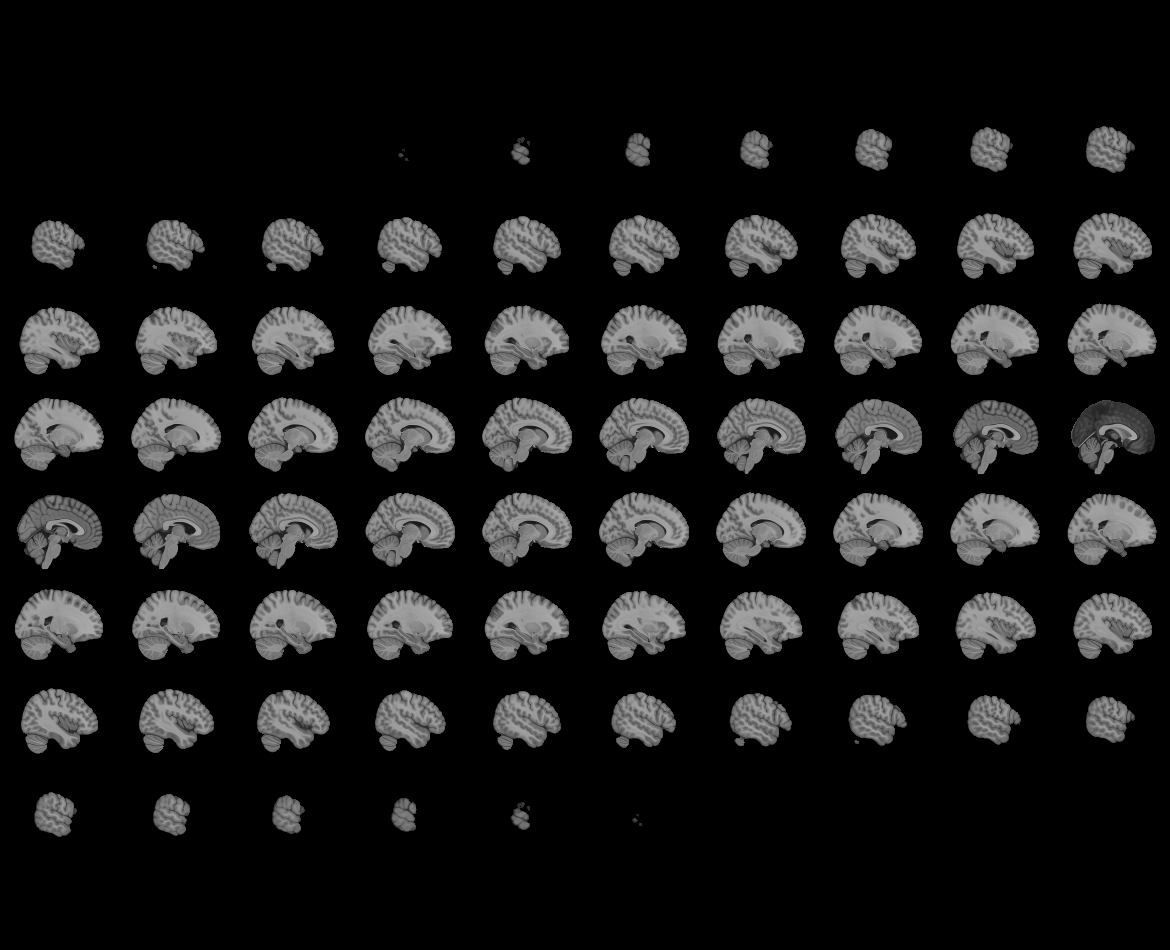
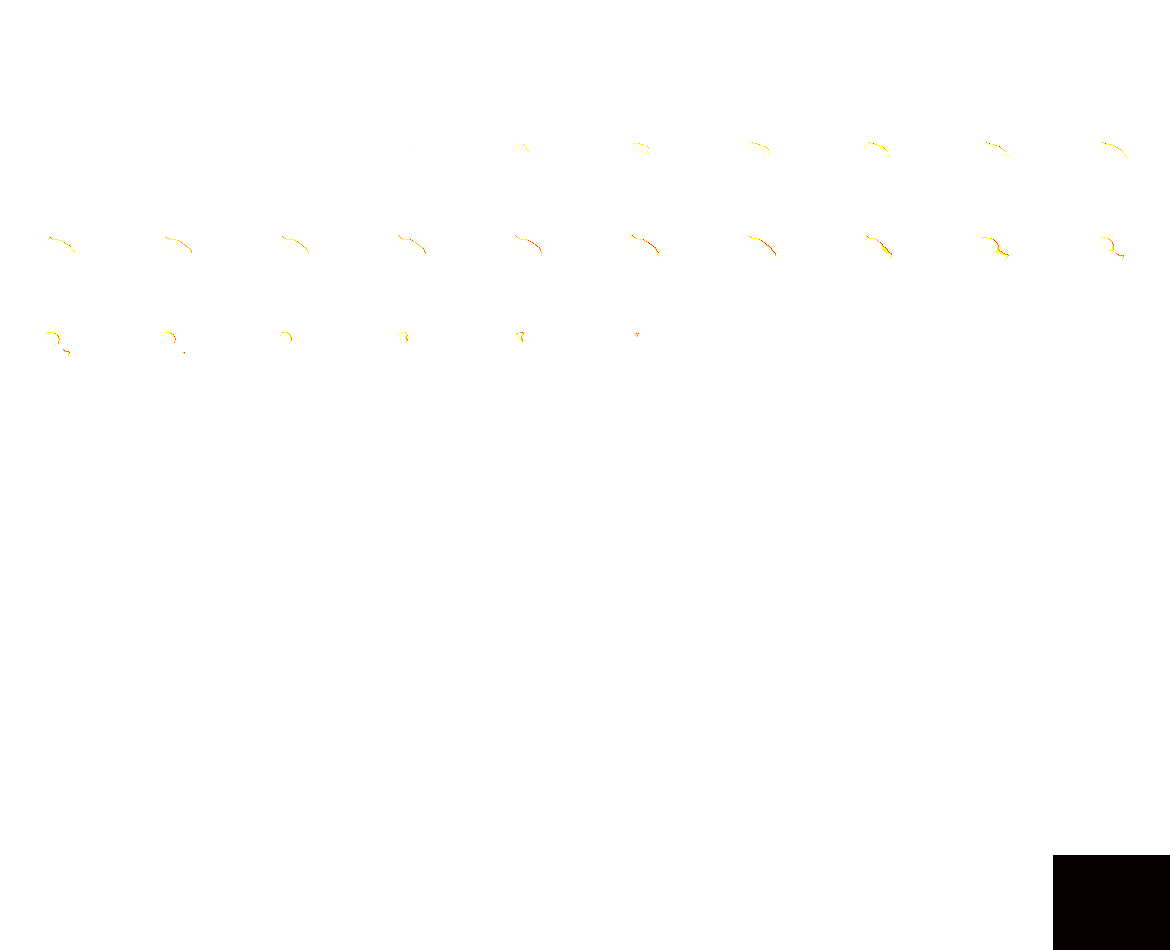

In [49]:
# Load cluster map
image_path = os.path.join(out_dir_group,
             f"group_task-{task_label}_clustermap_con-Q1234MinusNoise_c-fdr_p-0.005_clusterk-25.nii.gz")


cluster_map = image.load_img(image_path)

# plot cluster_map
#plotting.view_img(cluster_map, vmin=0, vmax=17, symmetric_cmap=False, cmap='Dark2')

# find unique values in cluster_map_g[0]
cluster_list = np.unique(cluster_map.get_fdata())

# remove zero (this is all of the clusters)
cluster_list = cluster_list[1:]

print(cluster_list)

# check first cluster
mask1 = math_img(f'img == {cluster_list[1]}', img=cluster_map)

plotting.view_img(mask1, vmax=1, vmin=0, symmetric_cmap=False, cmap='hot')


In [50]:
# extract z values and betas from clusters

# create a data frame of the z values for each ROI and each contrast
df = pd.DataFrame(columns=['subject', 'cluster', 'contrast', 'z_value', 'beta'])

for rr in range(len(cluster_list)):

    print(f"Extracting cluster {cluster_list[rr]}")

    mask1 = math_img(f'img == {cluster_list[rr]}', img=cluster_map)

    masker = NiftiMasker(mask_img=mask1, standardize=False)

    masker.fit()

    for subject in sub_labels:

        for cc in range(len(contrastList)):

            z_map_path = os.path.join(out_dir, f"sub-{subject}_task-{task_label}_stat-z_con-{contrastList[cc]}.nii.gz")
            beta_map_path = os.path.join(out_dir, f"sub-{subject}_task-{task_label}_stat-beta_con-{contrastList[cc]}.nii.gz")
            
            z_values = masker.transform(z_map_path)
            beta_values = masker.transform(beta_map_path)

            df.loc[len(df)] = [subject, cluster_list[rr], contrastList[cc], np.mean(z_values[0]), np.mean(beta_values[0])]   


Extracting cluster 1.0
Extracting cluster 2.0
Extracting cluster 3.0
Extracting cluster 4.0
Extracting cluster 5.0
Extracting cluster 6.0
Extracting cluster 7.0
Extracting cluster 8.0
Extracting cluster 9.0
Extracting cluster 10.0
Extracting cluster 11.0
Extracting cluster 12.0
Extracting cluster 13.0
Extracting cluster 14.0
Extracting cluster 15.0
Extracting cluster 16.0
Extracting cluster 17.0


In [51]:
df

,subject,cluster,contrast,z_value,beta
0,01,1.0,Q1MinusNoise,4.448241,0.639978
1,01,1.0,Q2MinusNoise,4.536051,0.610746
2,01,1.0,Q3MinusNoise,3.293147,0.476183
3,01,1.0,Q4MinusNoise,4.652509,0.539221
4,02,1.0,Q1MinusNoise,5.372721,0.687084
...,...,...,...,...,...
1287,18,17.0,Q4MinusNoise,1.472360,0.058776
1288,19,17.0,Q1MinusNoise,2.640375,0.598402
1289,19,17.0,Q2MinusNoise,2.860861,0.753658
1290,19,17.0,Q3MinusNoise,4.166700,1.159146


In [52]:
# save df as tsv
df.to_csv(os.path.join(out_dir_group, f"group_task-{task_label}_clustermap-values_c-fdr_p-0.005_clusterk-25.tsv"), sep='\t', index=False)

In [53]:
# Load tsv as dataframe
df = pd.read_csv(os.path.join(out_dir_group, f"group_task-{task_label}_clustermap-values_c-fdr_p-0.005_clusterk-25.tsv"), sep='\t')

In [54]:
df[df['cluster']==cluster_list[0]]

,subject,cluster,contrast,z_value,beta
0,1,1.0,Q1MinusNoise,4.448241,0.639978
1,1,1.0,Q2MinusNoise,4.536051,0.610746
2,1,1.0,Q3MinusNoise,3.293147,0.476183
3,1,1.0,Q4MinusNoise,4.652509,0.539221
4,2,1.0,Q1MinusNoise,5.372721,0.687084
...,...,...,...,...,...
71,18,1.0,Q4MinusNoise,7.069821,0.714847
72,19,1.0,Q1MinusNoise,5.329368,0.796816
73,19,1.0,Q2MinusNoise,3.528529,0.637497
74,19,1.0,Q3MinusNoise,5.351318,0.991188


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1MinusNoise vs. Q2MinusNoise: Mann-Whitney-Wilcoxon test two-sided, P_val:7.868e-04 U_stat=2.960e+02
Q1MinusNoise vs. Q3MinusNoise: Mann-Whitney-Wilcoxon test two-sided, P_val:7.868e-04 U_stat=2.960e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1MinusNoise vs. Q2MinusNoise: Mann-Whitney-Wilcoxon test two-sided, P_val:5.546e-03 U_stat=2.760e+02
Q1MinusNoise vs. Q3MinusNoise: Mann-Whitney-Wilcoxon test two-sided, P_val:1.785e-03 U_stat=2.880e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1MinusNoise vs.

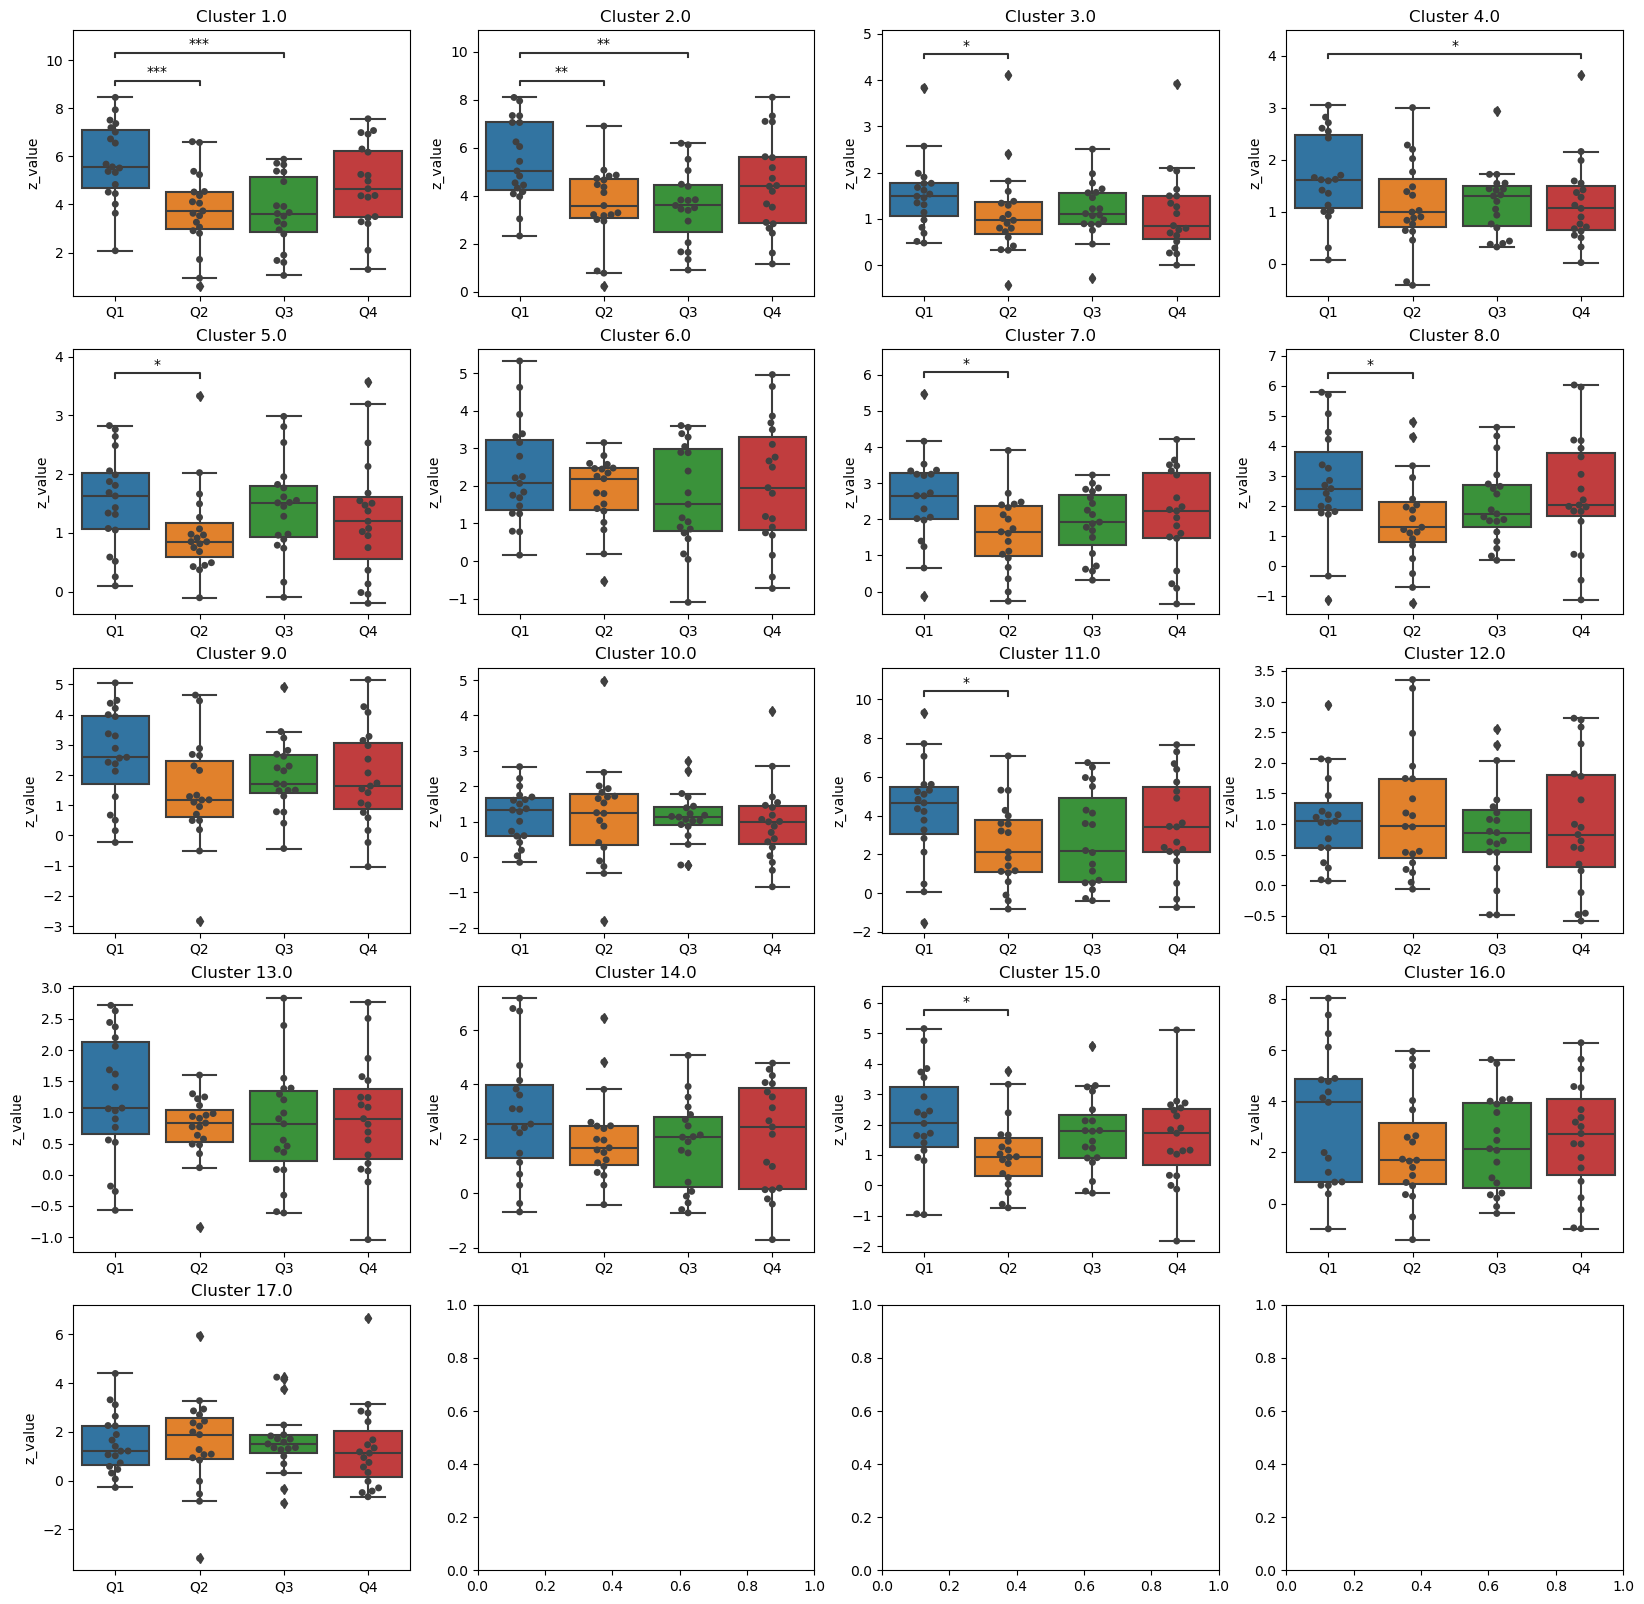

In [55]:
# create a box plot of the z values for the first cluster with the different contrasts and statistical comparison between contrasts
quad_list = ['Q1','Q2','Q3','Q4']
quad_pairs = list(combinations(contrastList, r=2))

# set up the figure
fig, ax = plt.subplots(5,4,figsize=(20, 20))

for rr in range(len(cluster_list)):
    # calculate subplot row and column indices
    row = rr // 4
    col = rr % 4

    # set up the boxplot
    sns.boxplot(x="contrast", y="z_value", data=df[df['cluster']==cluster_list[rr]], ax=ax[row, col])

    # add swarmplot
    sns.swarmplot(x="contrast", y="z_value", data=df[df['cluster']==cluster_list[rr]], color=".25", ax=ax[row, col])

    # add title
    ax[row, col].set_title(f"Cluster {cluster_list[rr]}")
    ax[row, col].set_xticklabels(quad_list)
    ax[row, col].set_xlabel('')

    # statistical comparisons between contrasts
    annotator = Annotator(ax[row, col], quad_pairs, data=df[df['cluster']==cluster_list[rr]], x='contrast', y='z_value', order=contrastList)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=1, comparisons_correction=None, hide_non_significant=True)
    annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1MinusNoise vs. Q3MinusNoise: Mann-Whitney-Wilcoxon test two-sided, P_val:3.191e-03 U_stat=2.820e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1MinusNoise vs. Q3MinusNoise: Mann-Whitney-Wilcoxon test two-sided, P_val:1.951e-02 U_stat=2.610e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
 

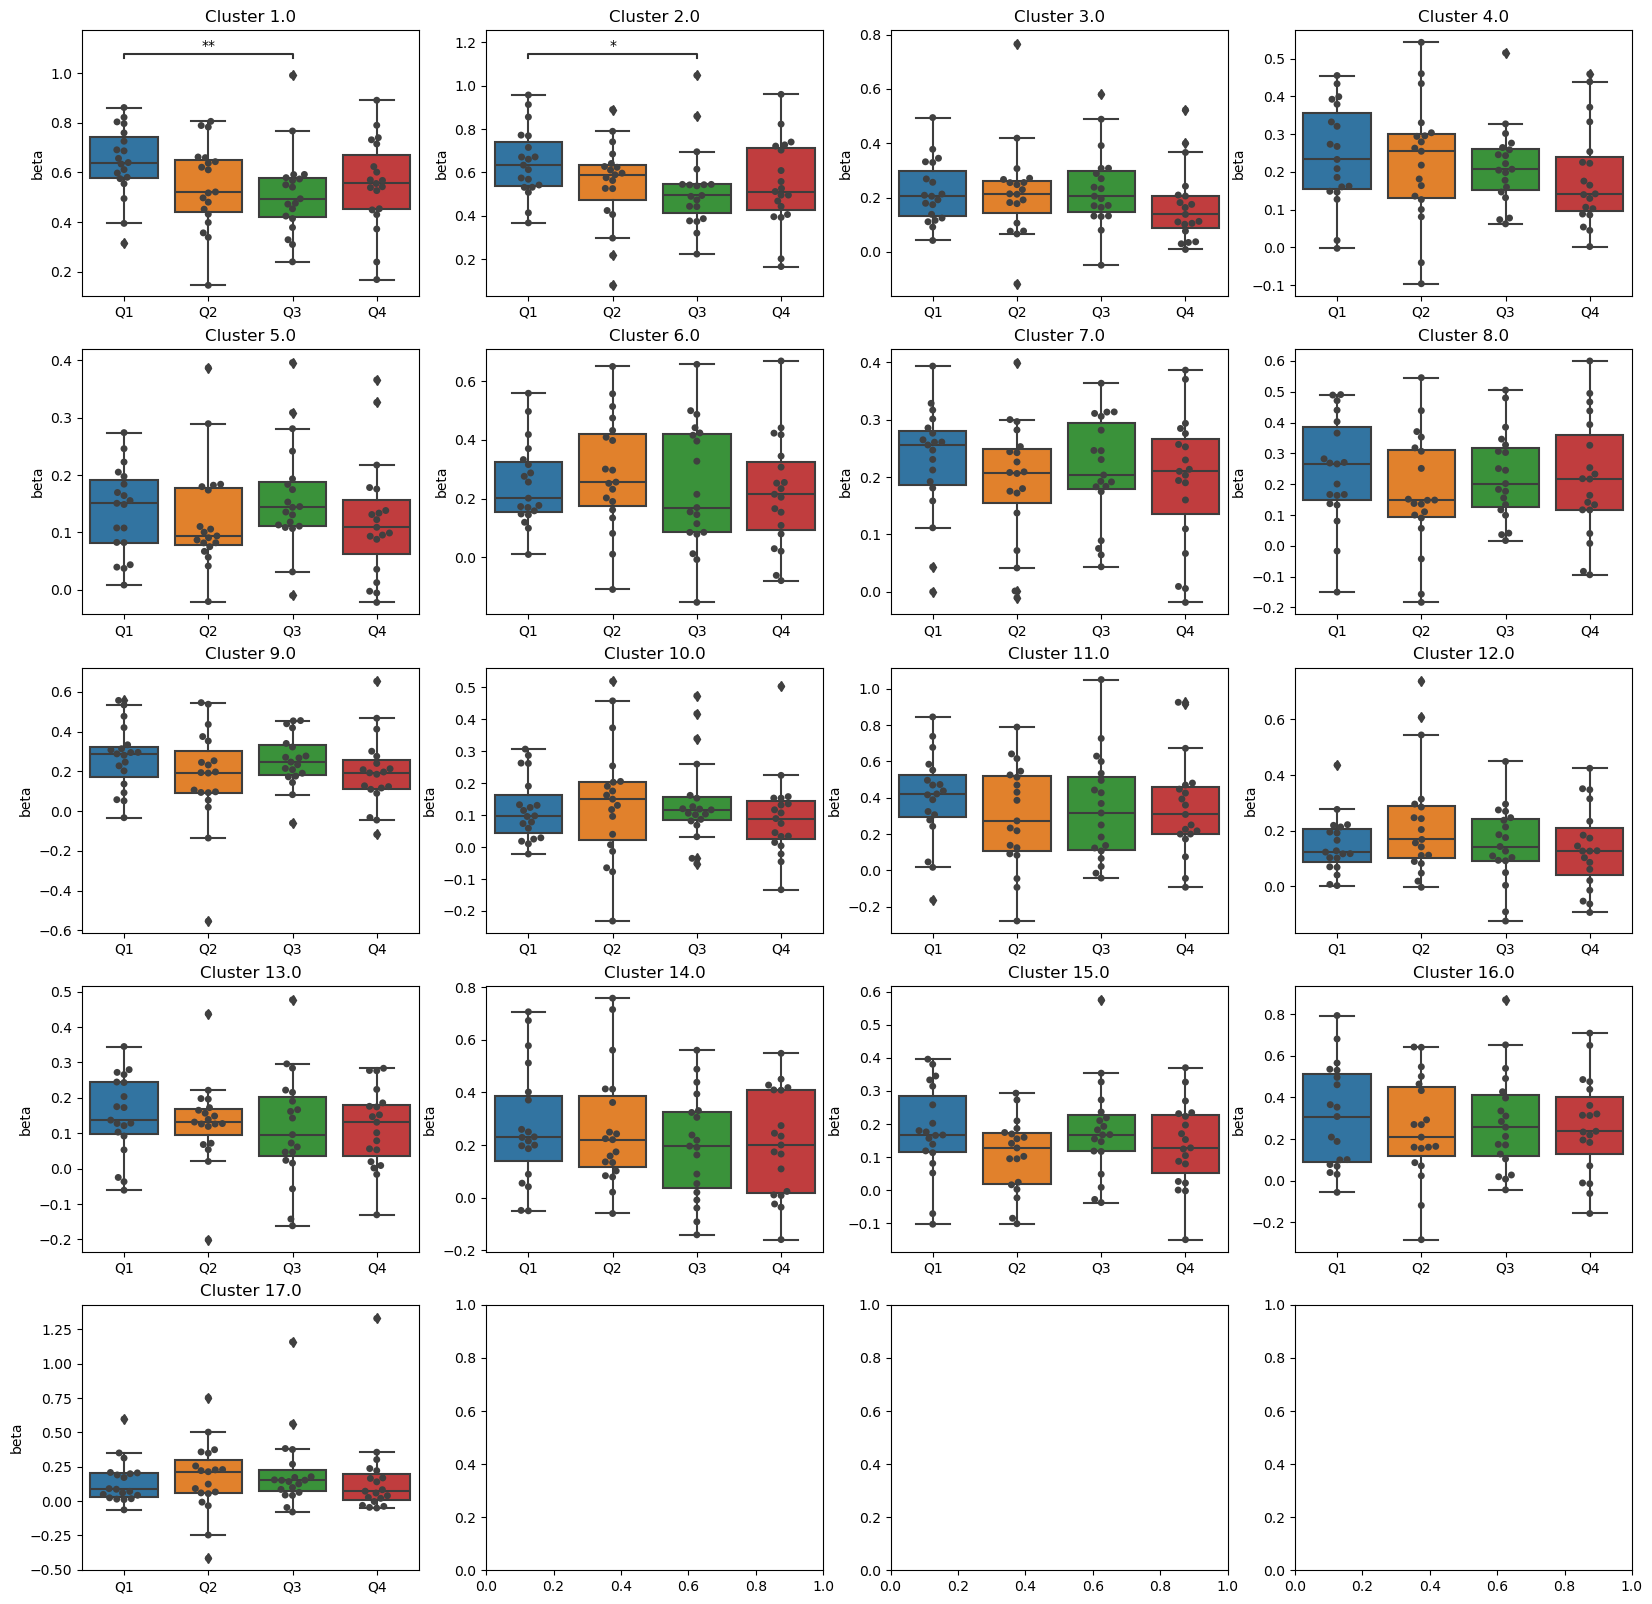

In [56]:
# create a box plot of the z values for the first cluster with the different contrasts and statistical comparison between contrasts
quad_list = ['Q1','Q2','Q3','Q4']
quad_pairs = list(combinations(contrastList, r=2))

# set up the figure
fig, ax = plt.subplots(5,4,figsize=(20, 20))

for rr in range(len(cluster_list)):
    # calculate subplot row and column indices
    row = rr // 4
    col = rr % 4

    # set up the boxplot
    sns.boxplot(x="contrast", y="beta", data=df[df['cluster']==cluster_list[rr]], ax=ax[row, col])

    # add swarmplot
    sns.swarmplot(x="contrast", y="beta", data=df[df['cluster']==cluster_list[rr]], color=".25", ax=ax[row, col])

    # add title
    ax[row, col].set_title(f"Cluster {cluster_list[rr]}")
    ax[row, col].set_xticklabels(quad_list)
    ax[row, col].set_xlabel('')

    # statistical comparisons between contrasts
    annotator = Annotator(ax[row, col], quad_pairs, data=df[df['cluster']==cluster_list[rr]], x='contrast', y='beta', order=contrastList)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=1, comparisons_correction=None, hide_non_significant=True)
    annotator.apply_and_annotate()